## hidden

In [5]:
!pip install nltk
!pip install numpy
!pip install scipy
!pip install scikit-learn
!pip install contractions
!pip install matplotlib
!pip install sentence_transformers

In [67]:
import os
from similarity import similarity
import nltk
nltk.download('wordnet')
nltk.download('brown')
import numpy as np
import time
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jadeynfeng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /Users/jadeynfeng/nltk_data...
[nltk_data]   Package brown is already up-to-date!


### preparing dataset

In [88]:
import json
import contractions

def pad_sequence(dataset):
    max_len = len(max(dataset, key=len))
    for i in range(len(dataset)):
        dataset[i] = dataset[i] + ["PAD"] * (max_len - len(dataset[i]))
    return dataset

def add_inherent_functions(row):
    for e in row["entities"]:
        tokens = row["tokens"]
        entity_type = e["type"].split("/")
        if entity_type[0] == "PhysicalObject":
            if len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
                if entity_type[1][:-6].lower() not in tokens:
                    tokens.append(entity_type[1][:-6].lower())
                # tokens.append(entity_type[1][-6:].lower())
    return tokens

    # BROKEN CODE
    # physical_object_indices = []
    # 
    # for e in row["entities"]:
    #     new_list = row["tokens"]
    #     entity_type = e["type"].split("/")
    #     if entity_type[0] == "PhysicalObject":
    #         if len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
    #             new_string = " ".join(new_list)
    #             if e["end"] == len(row["tokens"]):
    #                 replace_index = new_string.find(" ".join(row["tokens"][e["start"]:]))
    #                 new_string = new_string.replace(" ".join(row["tokens"][e["start"]:]))
    #             else:
    #                 replace_index = new_string.find(" ".join(row["tokens"][e["start"]:e["end"]]))
    #                 new_string = new_string.replace(" ".join(row["tokens"][e["start"]:e["end"]]), "")
    #             new_string = new_string[replace_index:]
    #             new_list = new_string.split()
    #             physical_object_indices.append((e["start"], e["end"], entity_type[1]))
    # for i in physical_object_indices:
    #     if i[1] == len(row["tokens"]):
    #         row["tokens"].append(i[2])
        

def clean_tokens(tokens):
    stopwords =["<num>", "<id>", "-"]
    tokens = [i for i in tokens if i not in stopwords]
    tokens = contractions.fix(" ".join(tokens)).split()
    return tokens

def prepare_dataset(filename):
    f = open(filename, "r")
    # returns JSON object as a dictionary
    data = json.load(f)

    dataset = []

    for datum in data:
        keep_indices = []
        for entity in datum["entities"]:
            if entity["type"].split("/")[0] not in ["PhysicalObject", "Activity"]:
                start = entity["start"]
                end = entity["end"]
                for i in range(start, end):
                    keep_indices.append(i)

        tokens = []
        for i in sorted(set(keep_indices)):
            tokens.append(datum["tokens"][i])
        
        tokens = clean_tokens(tokens)
        if tokens:
            dataset.append(" ".join(tokens))
    # dataset = pad_sequence(dataset)
    return dataset

def full_dataset(filename):
    f = open(filename, "r")
    # returns JSON object as a dictionary
    data = json.load(f)

    d = []

    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if "State" in types or "Process" in types or "Property" in types:
            tokens = clean_tokens(datum["tokens"])
            d.append(" ".join(tokens))
    # d = pad_sequence(dataset)
    return d

def full_dataset_append_inherent_functions(filename):
    f = open(filename, "r")
    # returns JSON object as a dictionary
    data = json.load(f)

    d = []

    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if "State" in types or "Process" in types or "Property" in types:
            tokens = add_inherent_functions(datum)
            tokens = clean_tokens(tokens)
            d.append(" ".join(tokens))
    return d

In [89]:
dataset = full_dataset("../data/gold_release.json")
np.random.seed(42)
random_sampled_dataset = np.random.choice(dataset, 100, replace=False)
print(dataset)
inherent_function_dataset = full_dataset_append_inherent_functions("../data/gold_release.json")
print(inherent_function_dataset)

['air conditioner thermostat not working', 'air conditioner thermostat unserviceable', 'air conditioner unserviceable', 'air conditioner unserviceable when stationary', 'air conditioner warm', 'air filters plugged', 'air horn disconnected', 'air horn does not work', 'air horn fault', 'air horn not working', 'air horn not working compressor awaiting', 'air horn stuck on', 'air horn unserviceable', 'air horn working intermittently', 'air leak', 'air leak near side of door', 'air leaking from line outside', 'airhorn not working', 'alarm on VIMS does not work', 'all dash lights on', 'alternator drive leaking', 'alternator failed', 'alternator not charging', 'alternator overcharge fault', 'alternator overcharged', 'analyse failed driveline component', 'and lube system faults', 'armrest unserviceable', 'auto-greaser leaking oil', 'auto-greaser unserviceable', 'auto-lube error PO', 'auto-spray feature not working', 'axle temperature fault', 'axle temperature sensor fault', 'back rest unservic

## Paper: Sentence Similarity Based on Semantic Nets and Corpus Statistics

### Average clustering

/opt/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


number right hand air brake line needs replacing & - air conditioner fault
0.2087392681661242
number right hand air brake line needs replacing & diagnose / repair fuel fault
0.20884554038458686
number right hand air brake line needs replacing & broken left hand side mirror
0.43937089704108107
number right hand air brake line needs replacing & - HMU hose weeping
0.16899576674982242
number right hand air brake line needs replacing & compressor oil pressure switch unserviceable
0.2358521736384291
number right hand air brake line needs replacing & ground fault in propel
0.267330316054795
number right hand air brake line needs replacing & steering hub caps require replacing
0.517018002747297
number right hand air brake line needs replacing & centrifugal oil filter leaking
0.12914215643535615
number right hand air brake line needs replacing & radiator blocked with grass
0.2793643696385828
number right hand air brake line needs replacing & - ripper shank broken
0.2593336783109326
number right

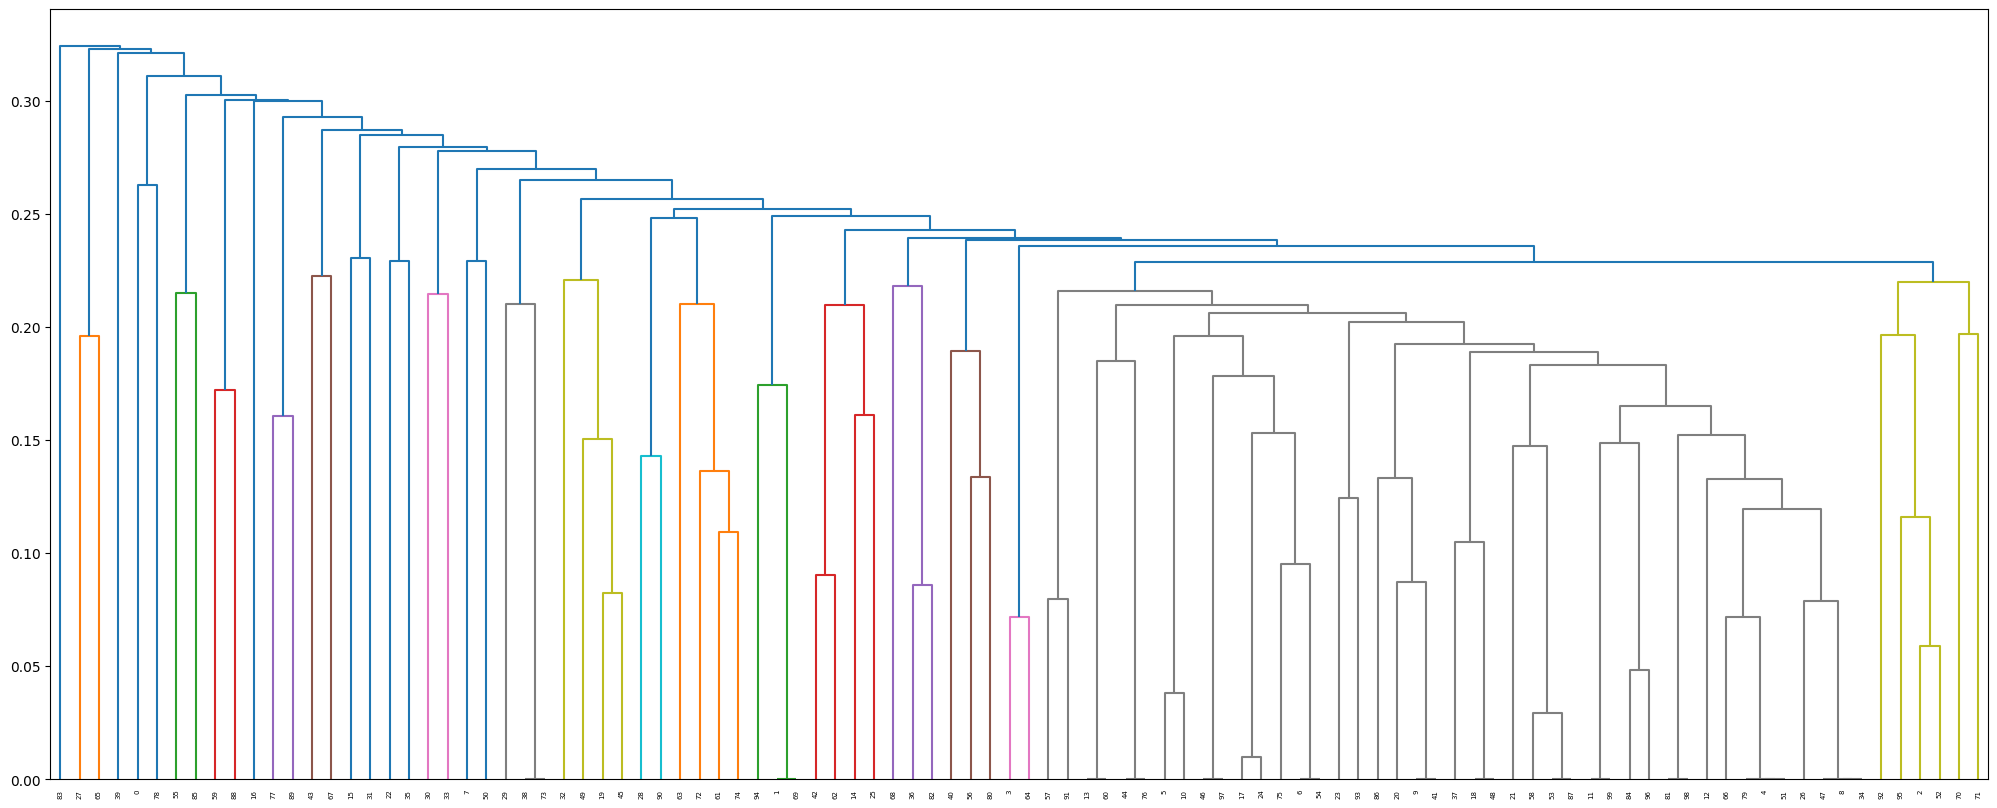

In [38]:
similarity_matrix=[]

for i in range(0,len(random_sampled_dataset)):
    for j in range(i+1, len(random_sampled_dataset)):
        sentList1=random_sampled_dataset[i]
        sentList2=random_sampled_dataset[j]
        sim = similarity(sentList1,sentList2)
        
        # print(sentList1,"&",sentList2)
        # print(sim)
        similarity_matrix.append(sim)
    print(i/len(random_sampled_dataset)*100,"% done")

# Calculate execution time
end = time.time()
dur = end-start
print("")
if dur<60:
    print("Execution Time:",dur,"seconds")
elif dur>60 and dur<3600:
    dur=dur/60
    print("Execution Time:",dur,"minutes")
else:
    dur=dur/(60*60)
    print("Execution Time:",dur,"hours")


Z = linkage(similarity_matrix, 'average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [39]:
k=24
cluster_labels = fcluster(Z, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(random_sampled_dataset[j])
    print()

Cluster 1 :
repair air conditioner and wiring fault
left hand rear brake cooling hose leaking

Cluster 2 :
number right hand air brake line needs replacing

Cluster 3 :
change out leaking implement pump

Cluster 4 :
cracks in back right hand side handrail
change out leaking relay valve

Cluster 5 :
repair crack in rear cross member
brake cooling return hose leaking

Cluster 6 :
air horn not working
- repair engine oil leaking

Cluster 7 :
change position flat tyre
broken fuel cooler mounts

Cluster 8 :
cutting edges need change out
broken grease plug

Cluster 9 :
collect broken tooth
movement found right hand engine mount

Cluster 10 :
repair cracked roof skin left hand side exhaust
cooler return pipe coupling leak

Cluster 11 :
steering hub caps require replacing
boarding gate hinge broken

Cluster 12 :
air conditioner belt broken
brake release fault
replace leaking scavenge pump

Cluster 13 :
repair fuel fault
broken clamp on crowd cylinder hose TBC
generator flow regulator unservice

### Ward clustering

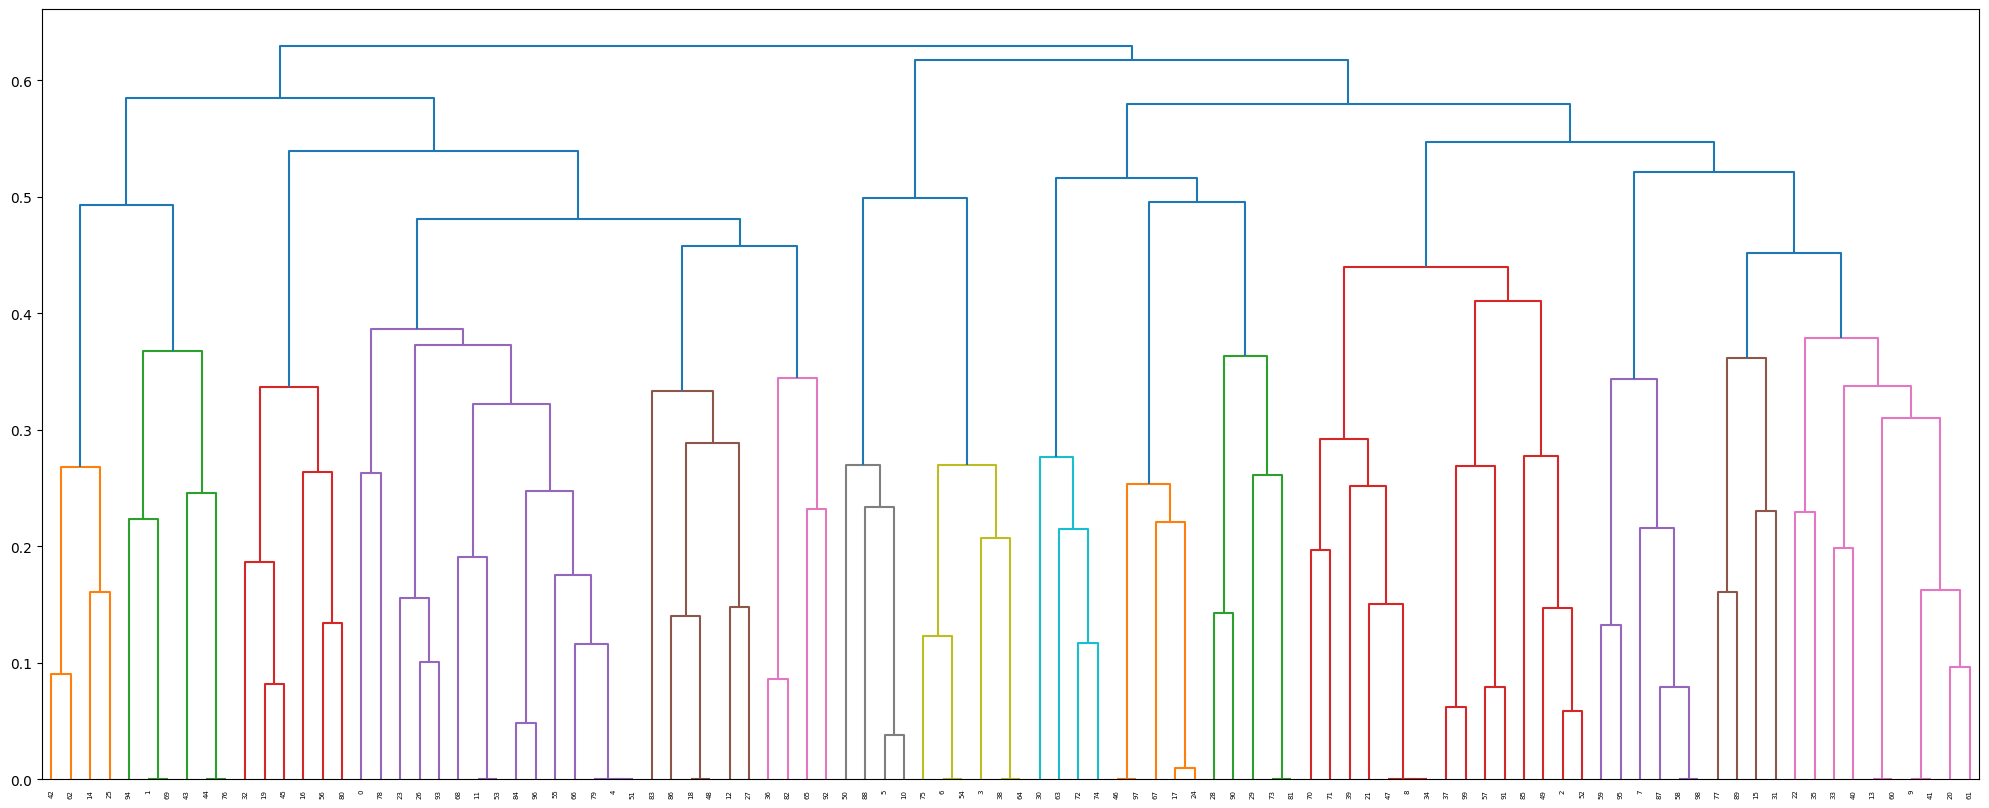

In [42]:
Z = linkage(similarity_matrix, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [45]:
k=15
cluster_labels = fcluster(Z, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(random_sampled_dataset[j])
    print()

Cluster 1 :
middle air drain tap leaking
- brake hose needs to be replaced
coolant leak at engine oil cooler
IOV fault on drag package

Cluster 2 :
- air conditioner fault
change position flat tyre
- fuel cap is missing
brake cooling hose leaking rear
broken hinge
handrail above battery box cracked

Cluster 3 :
right hand PTO cavity emptying
repair fuel fault
broken clamp on crowd cylinder hose TBC
generator flow regulator unserviceable
water separator leaking fuel
replace position tyre - mismatched

Cluster 4 :
number right hand air brake line needs replacing
- HMU hose weeping
voltage regulator fuse fault
oil leak at diverter valve
air horn disconnected
air conditioner unserviceable
replace oil leaks
cracks in back right hand side handrail
investigate / repair joystick needs repair
- engine bay light blown
change out leaking implement pump
inverter earthing out
start motorvator and set limits
change out blown steering hose
grease distributor leaking

Cluster 5 :
crack in windscreen
c

### Centroid Clustering

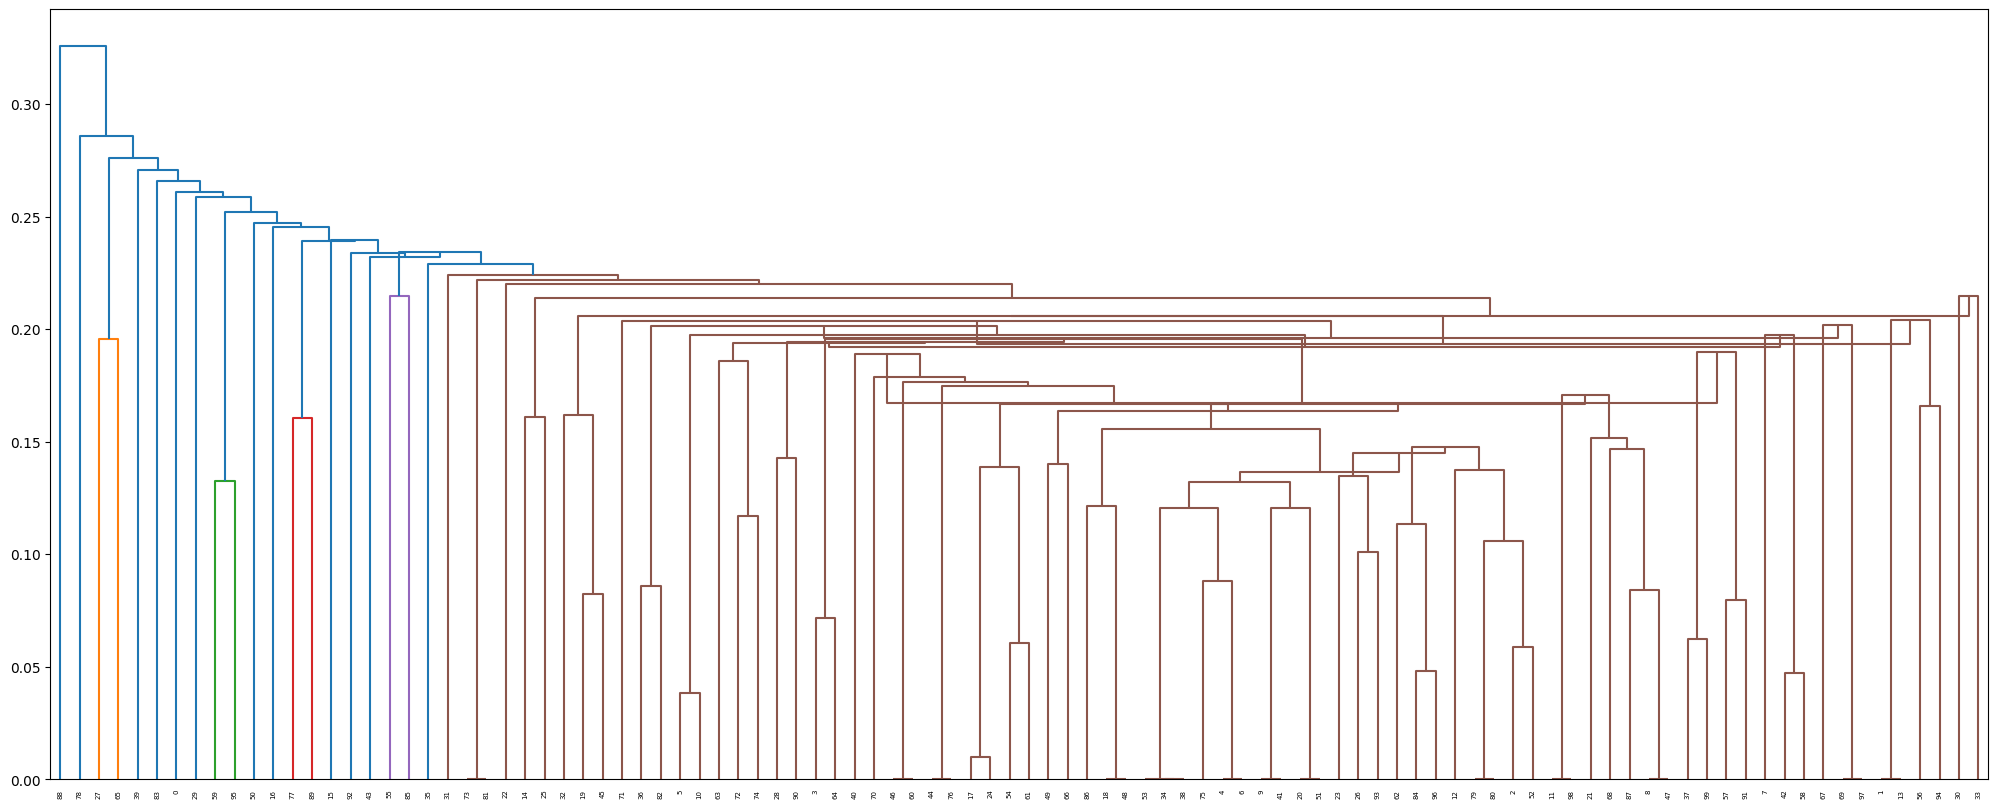

In [46]:
Z = linkage(similarity_matrix, 'centroid')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [49]:
k=17
cluster_labels = fcluster(Z, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(random_sampled_dataset[j])
    print()

Cluster 1 :
repair air conditioner and wiring fault
left hand rear brake cooling hose leaking

Cluster 2 :
repair crack in rear cross member
brake cooling hose leaking

Cluster 3 :
air horn not working
- repair engine oil leaking

Cluster 4 :
cracks in back right hand side handrail
change out leaking relay valve

Cluster 5 :
- air conditioner fault
diagnose / repair fuel fault
broken left hand side mirror
- HMU hose weeping
compressor oil pressure switch unserviceable
ground fault in propel
steering hub caps require replacing
centrifugal oil filter leaking
radiator blocked with grass
- ripper shank broken
voltage regulator fuse fault
crack in windscreen
blown brake hose
middle air drain tap leaking
cracks in diagonal braces in front
coolant leak
repair fuel fault
- repair leaking centrifugal filter
air horn not working compressor awaiting
collect broken tooth
oil leak at diverter valve
grease pump is bypassing air
- brake hose needs to be replaced
air horn disconnected
boarding ladder 

# Sentence Transformer Embedding

## using randomly sampled dataset

In [40]:
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import fcluster

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(random_sampled_dataset)

similarity_matrix2 = model.similarity(embeddings,embeddings)

/opt/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Average clustering

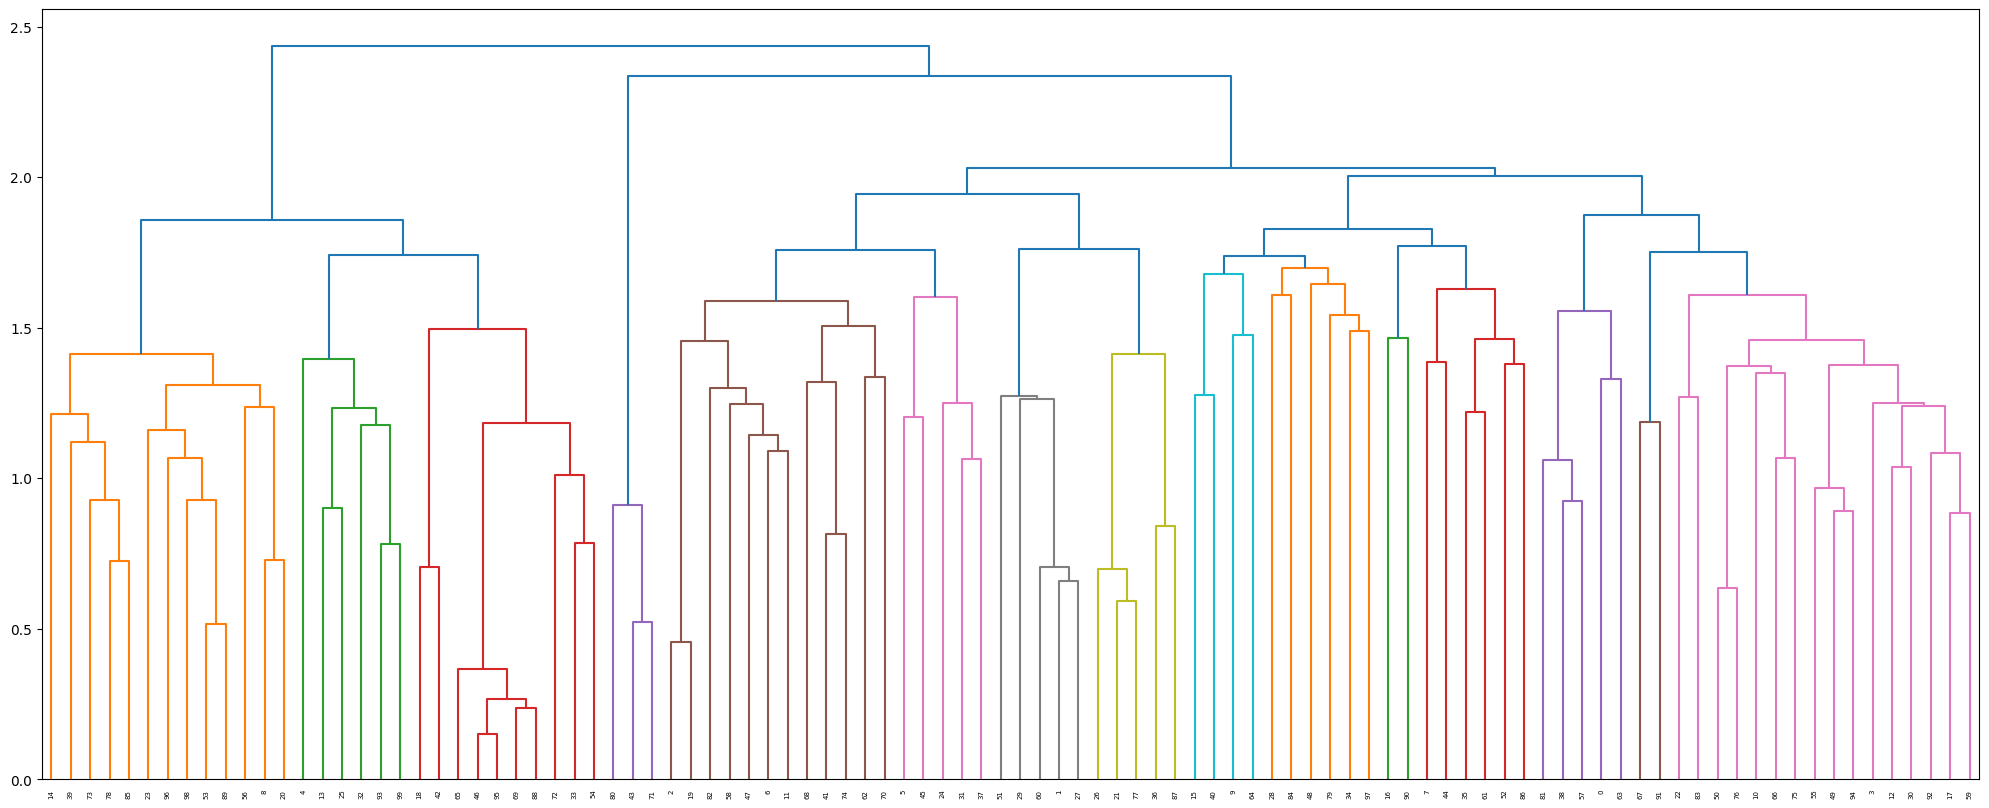

In [41]:
Z = linkage(similarity_matrix2, 'average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [45]:
k=15
cluster_labels = fcluster(Z, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(random_sampled_dataset[j])
            for word in random_sampled_dataset[j].split():
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(5):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
centrifugal oil filter leaking
middle air drain tap leaking
- repair leaking centrifugal filter
oil leak at diverter valve
repair leak in pilot valve solenoid
replace oil leaks
water separator leaking fuel
replace leaking scavenge pump
change out leaking implement pump
change out leaking relay valve
- repair engine oil leaking
grease distributor leaking
replace hydraulic oil leak text
Top words:
leaking
oil
repair
leak
valve

Cluster 2 :
- HMU hose weeping
blown brake hose
- brake hose needs to be replaced
broken clamp on crowd cylinder hose TBC
change out blown steering hose
blown steering hose
Top words:
hose
blown
-
brake
steering

Cluster 3 :
coolant leak
cooler return pipe coupling leak
coolant leak at engine oil cooler
leaking brake cooling hose
differential cooler hose leaking
left hand rear brake cooling hose leaking
brake cooling hose leaking rear
differential pump motor hose leaking
brake cooling return hose leaking
brake cooling hose leaking
Top words:
leaking
ho

### Ward clustering

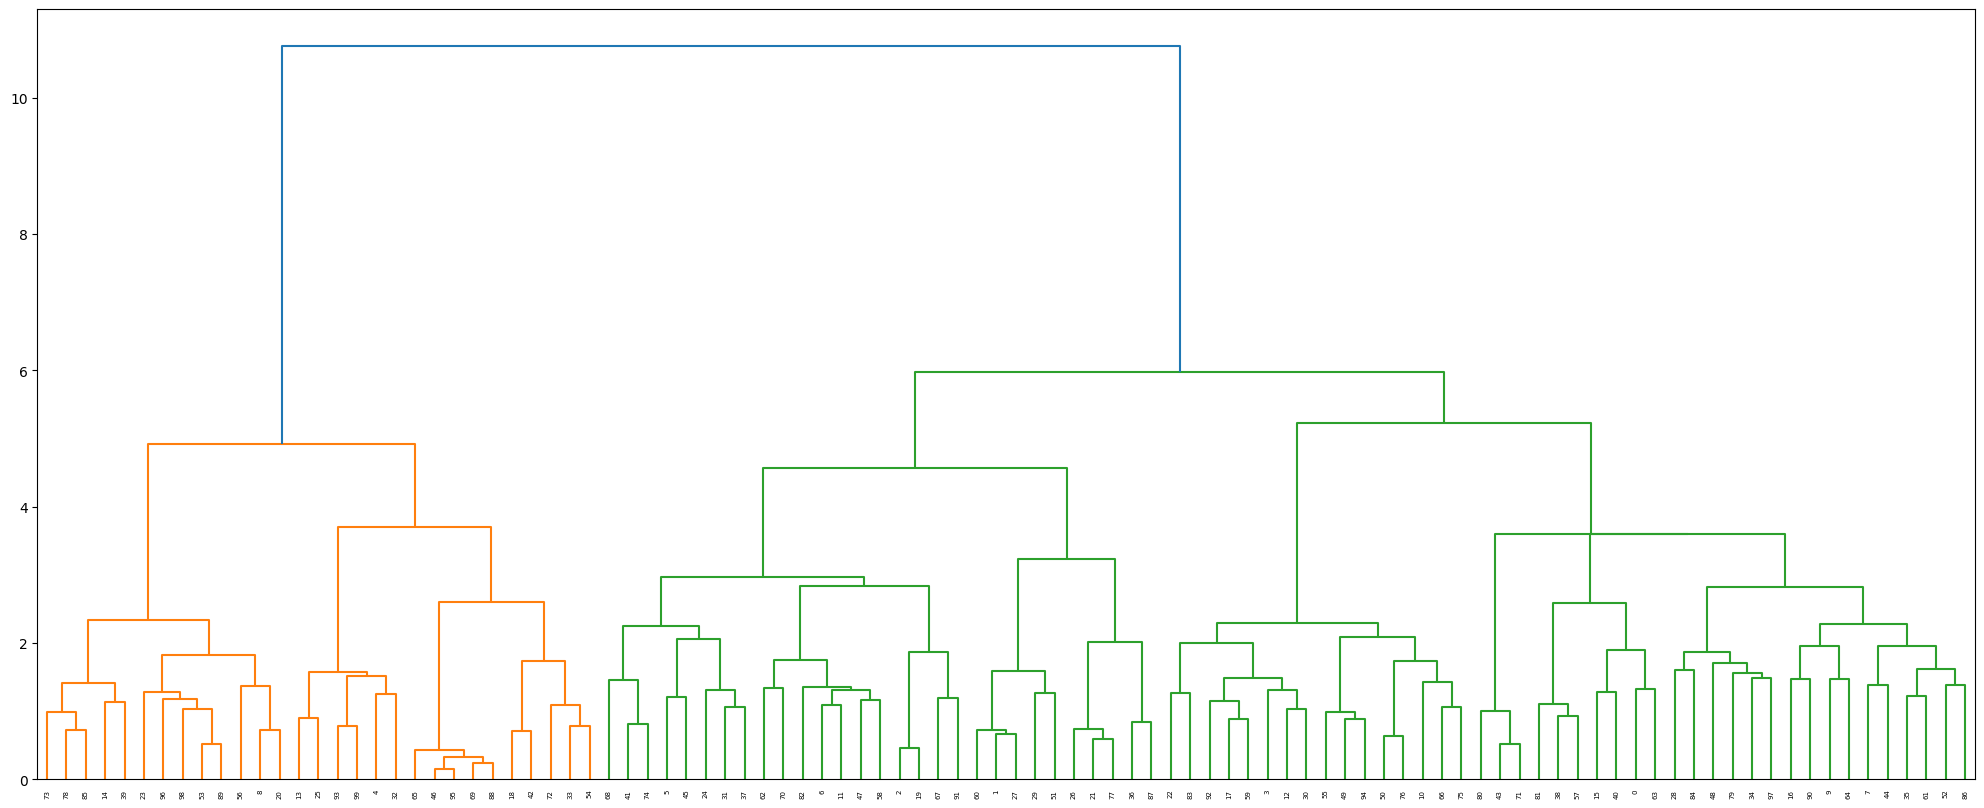

In [46]:
Z = linkage(similarity_matrix2, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [48]:
k=16
cluster_labels = fcluster(Z, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(random_sampled_dataset[j])
            for word in random_sampled_dataset[j].split():
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(5):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
middle air drain tap leaking
repair leak in pilot valve solenoid
replace leaking scavenge pump
change out leaking implement pump
change out leaking relay valve
Top words:
leaking
valve
pump
change
out


Cluster 2 :
centrifugal oil filter leaking
- repair leaking centrifugal filter
oil leak at diverter valve
replace oil leaks
water separator leaking fuel
- repair engine oil leaking
grease distributor leaking
replace hydraulic oil leak text
Top words:
oil
leaking
centrifugal
filter
-


Cluster 3 :
- HMU hose weeping
blown brake hose
- brake hose needs to be replaced
broken clamp on crowd cylinder hose TBC
change out blown steering hose
blown steering hose
Top words:
hose
blown
-
brake
steering


Cluster 4 :
leaking brake cooling hose
left hand rear brake cooling hose leaking
brake cooling hose leaking rear
brake cooling return hose leaking
brake cooling hose leaking
Top words:
leaking
brake
cooling
hose
rear


Cluster 5 :
coolant leak
cooler return pipe coupling leak
coolant 

### centroid clustering

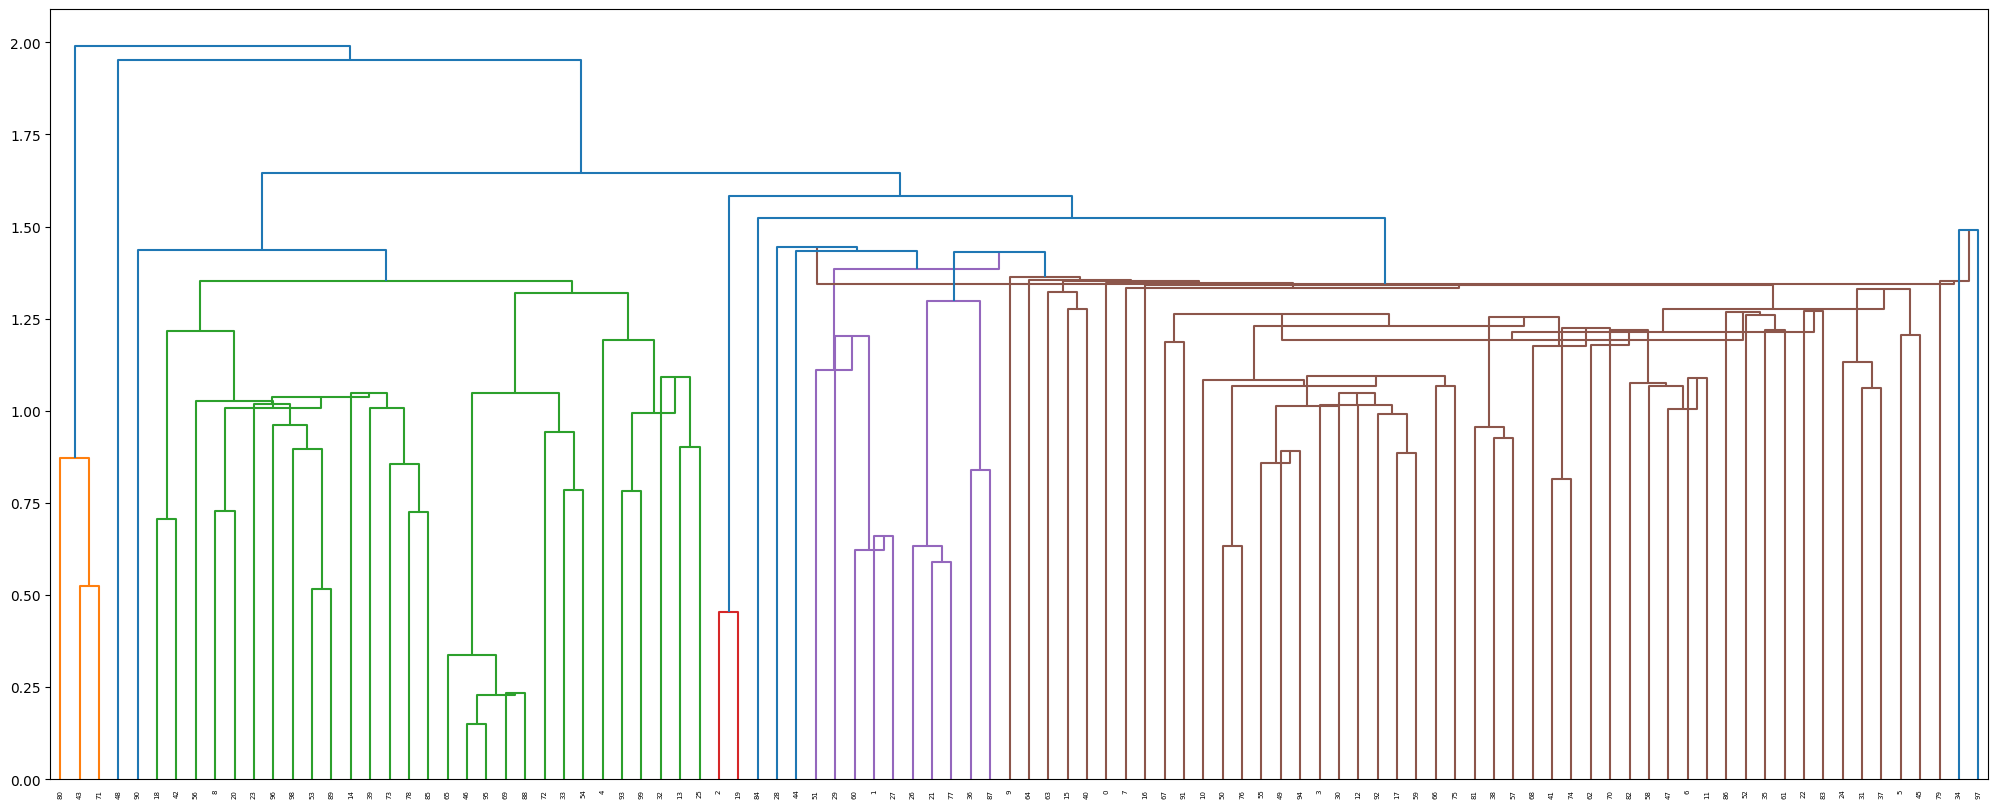

In [49]:
Z = linkage(similarity_matrix2, 'centroid')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [52]:
k=12
cluster_labels = fcluster(Z, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(random_sampled_dataset[j])
            for word in random_sampled_dataset[j].split():
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
change position flat tyre
change out worn position tyre
replace position tyre - mismatched
Top words:
position
tyre
change
flat
out

Cluster 2 :
- HMU hose weeping
centrifugal oil filter leaking
blown brake hose
middle air drain tap leaking
coolant leak
- repair leaking centrifugal filter
oil leak at diverter valve
- brake hose needs to be replaced
broken clamp on crowd cylinder hose TBC
cooler return pipe coupling leak
repair leak in pilot valve solenoid
coolant leak at engine oil cooler
leaking brake cooling hose
replace oil leaks
differential cooler hose leaking
water separator leaking fuel
left hand rear brake cooling hose leaking
brake cooling hose leaking rear
differential pump motor hose leaking
replace leaking scavenge pump
change out leaking implement pump
change out leaking relay valve
brake cooling return hose leaking
- repair engine oil leaking
change out blown steering hose
brake cooling hose leaking
grease distributor leaking
replace hydraulic oil leak text
bl

## with entire gold maintie set

In [61]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(dataset)

similarity_matrix3 = model.similarity(embeddings,embeddings)

### Average clustering

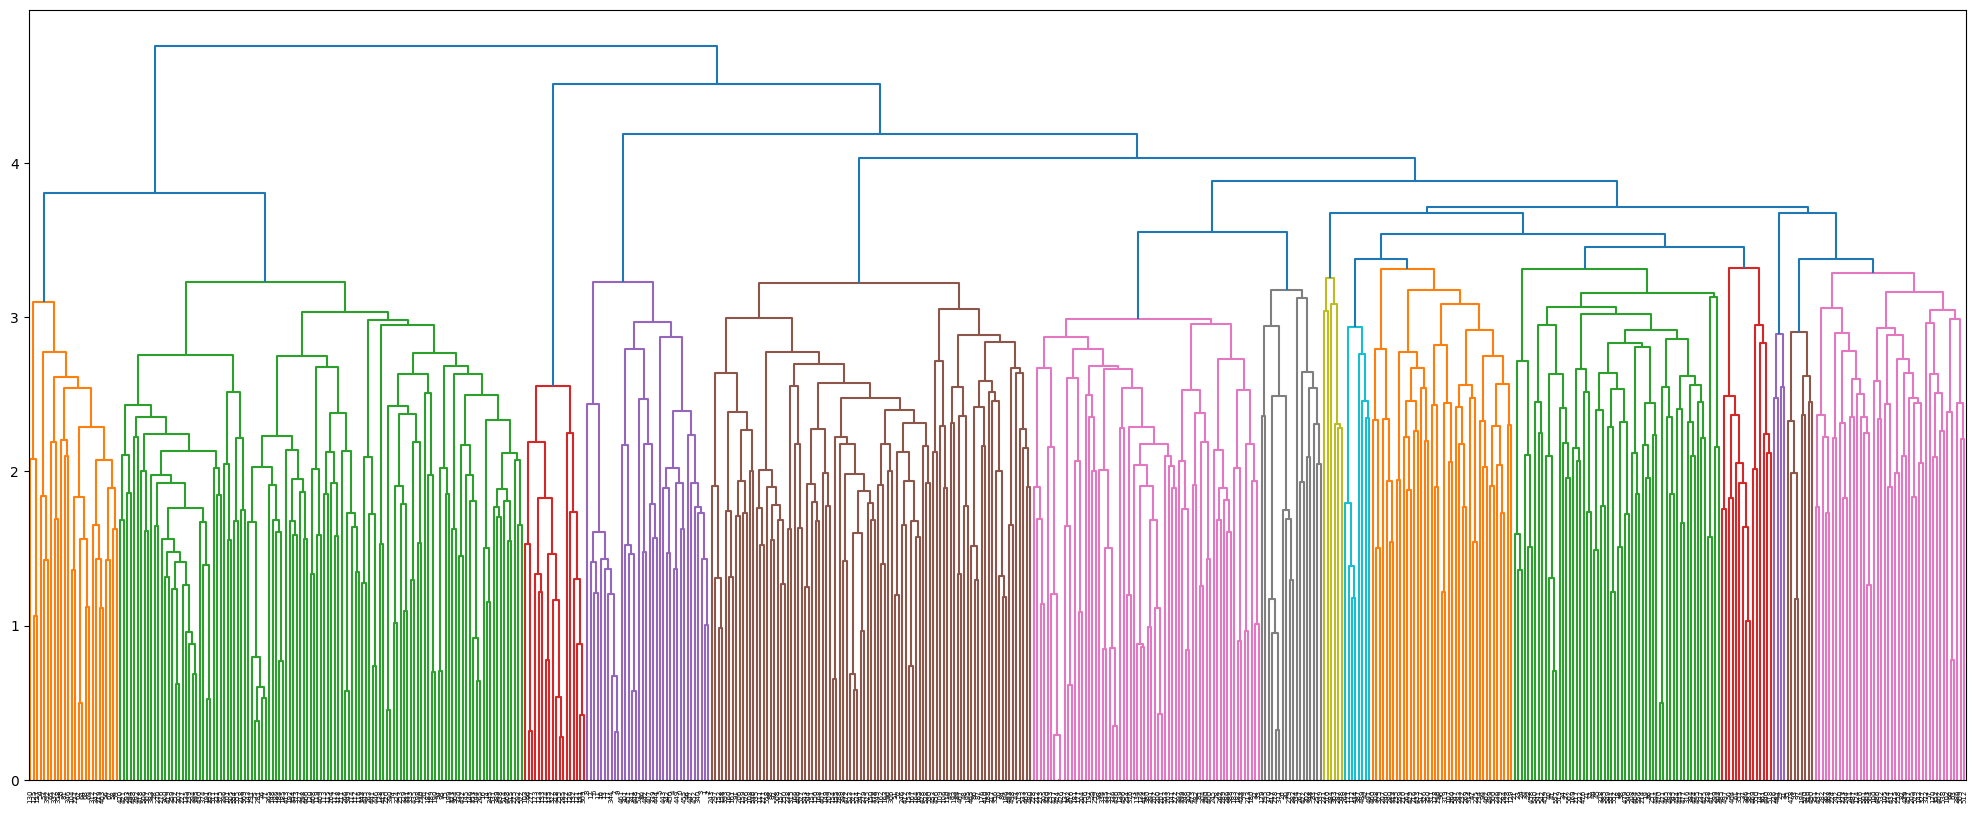

In [22]:
Z = linkage(similarity_matrix3, 'average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [25]:
k=15
cluster_labels = fcluster(Z, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(dataset[j])
            for word in dataset[j].split():
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(5):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
blown air conditioner hose
blown air conditioner hose to radiator
blown brake hose
blown crowd cylinder hose
blown hose in hitch
blown hose on boom
blown o-ring off steering hose
blown o-ring on steering hose
blown oil cooler hose - x metre
blown right hand bucket cylinder hose
blown steering hose
blown steering pump hose
broken clamp on crowd cylinder hose TBC
change out blown steering hose
change out unserviceable left hand bucket cylinder hose
change out unserviceable right hand clam cylinder hose
change out weeping boom cylinder hose
replace blown implement hose
replace blown right hand steering hose
replace blown main pump hose
- HMU hose weeping
- brake hose needs to be replaced
- change out blown hose
- engine fan hose weeping
- repair blown air conditioner hose
- replace blown hose
Top words:
hose
blown
-
cylinder
steering

Cluster 2 :
air leak
air leak near side of door
air leaking from line outside
alternator drive leaking
auto-greaser leaking oil
both stick cylin

### Ward clustering

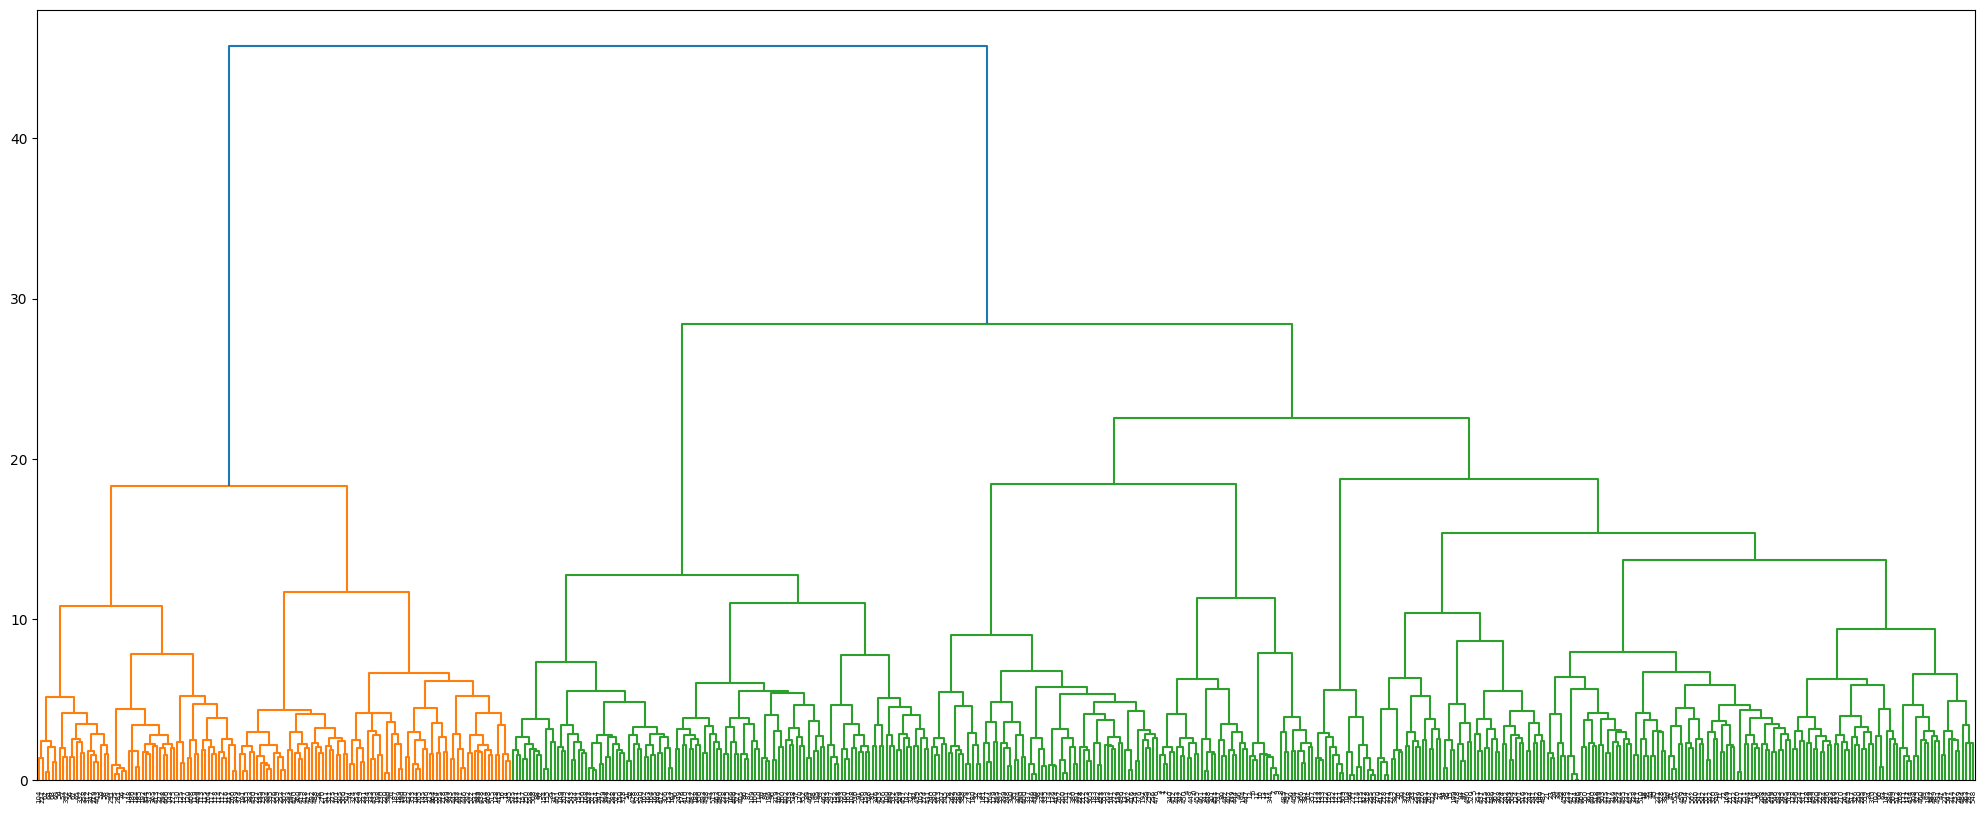

In [18]:
Z = linkage(similarity_matrix3, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [19]:
k=10
cluster_labels = fcluster(Z, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(dataset[j])
    print()

Cluster 1 :
blown air conditioner hose
blown air conditioner hose to radiator
blown brake hose
blown crowd cylinder hose
blown hose in hitch
blown hose on boom
blown o-ring off steering hose
blown o-ring on steering hose
blown oil cooler hose - x metre
blown right hand bucket cylinder hose
blown steering hose
blown steering pump hose
brake cooling hose leaking
brake cooling hose leaking rear
brake cooling return hose leaking
change out blown steering hose
change out leak slew motor hose
change out leaking HMU on next
change out leaking fan hoses
change out leaking heater taps
change out leaking hydraulic hose
change out leaking implement pump
change out leaking relay valve
change out leaking steering hose
change out left hand steering cylinder leaking
change out unserviceable left hand bucket cylinder hose
change out unserviceable right hand clam cylinder hose
change out weeping boom cylinder hose
coolant hose leaking at right hand bottom
cooler return pipe coupling leak
differential c

### centroid clustering

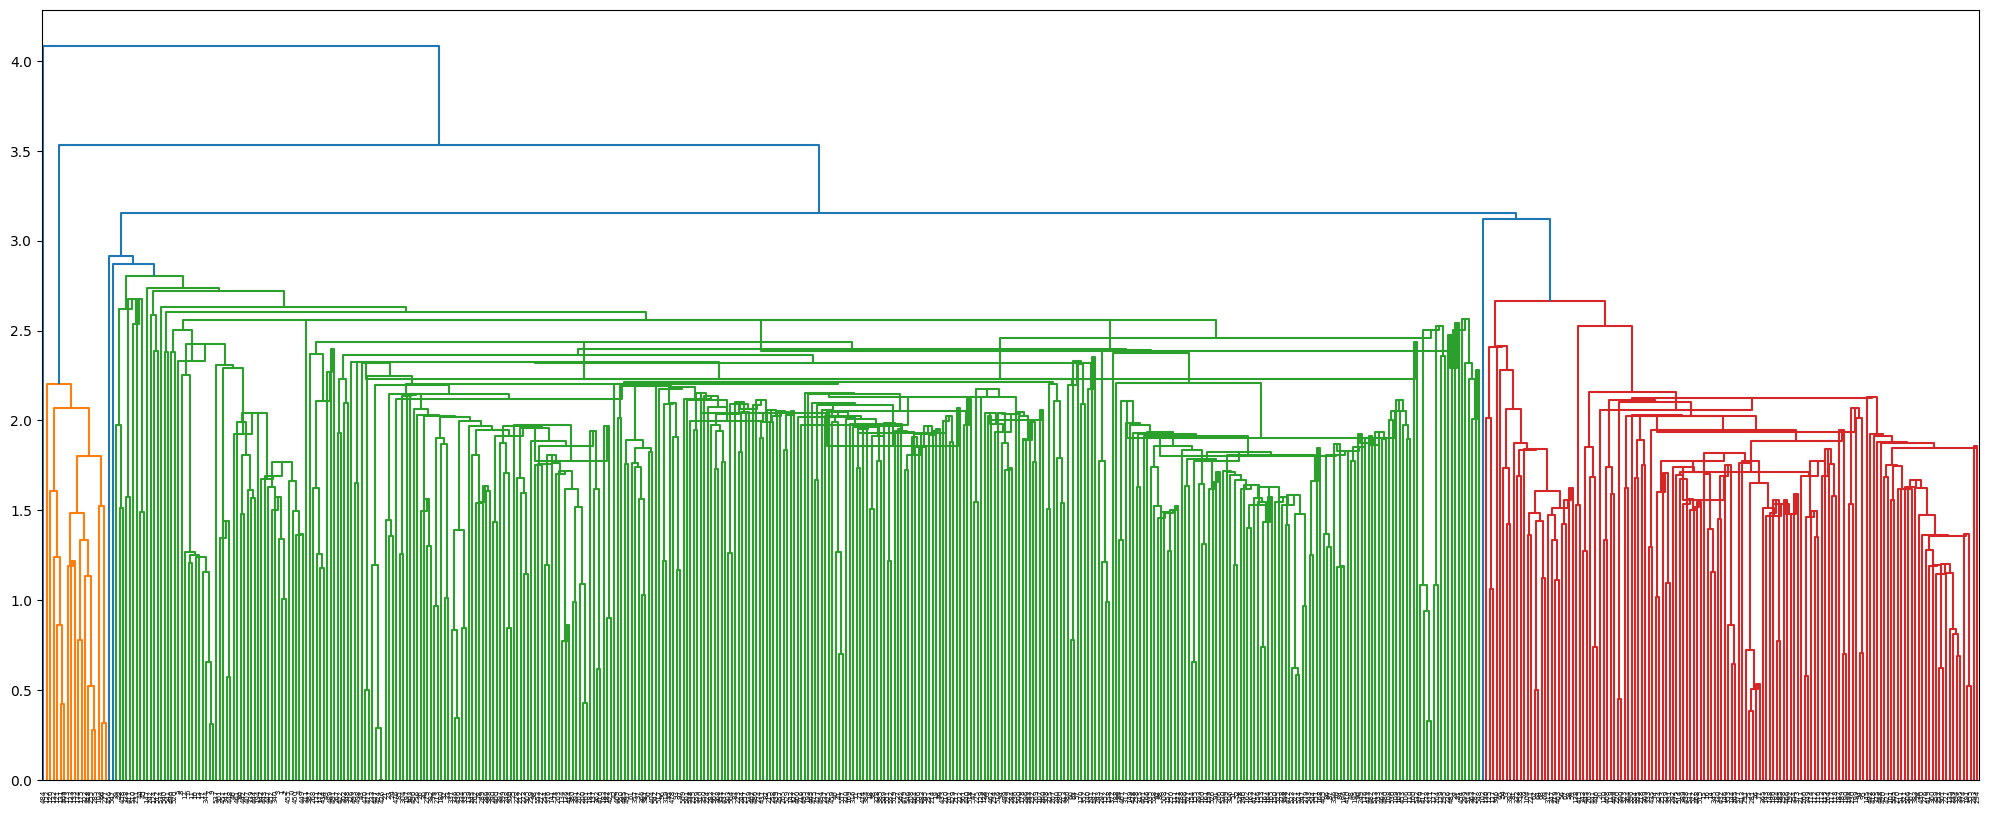

In [20]:
Z = linkage(similarity_matrix3, 'centroid')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [21]:
k=6
cluster_labels = fcluster(Z, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(dataset[j])
    print()

Cluster 1 :
blown position tyre
change out blown position tyre
change out position and tyre worn out
change out position tyre - sensor not reading
change out position tyre damage
change out unserviceable position tyre
change out worn position tyre
change position flat tyre
change position tyre damage text
damage to position tyre
damaged position tyre
damaged position tyre and rim
replace damaged position tyre and position
position tyre blown
replace damaged tyre on position
change out position tyre worn
replace position tyre damaged
replace position tyre - mismatched

Cluster 2 :
air conditioner thermostat not working
air conditioner thermostat unserviceable
air conditioner unserviceable
air conditioner unserviceable when stationary
air conditioner warm
air filters plugged
air horn disconnected
air horn does not work
air horn fault
air horn not working
air horn not working compressor awaiting
air horn stuck on
air horn unserviceable
air horn working intermittently
airhorn not working
a

## Entire gold with inherent function dataset

In [90]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(inherent_function_dataset)

similarity_matrix4 = model.similarity(embeddings,embeddings)

/opt/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### average clustering

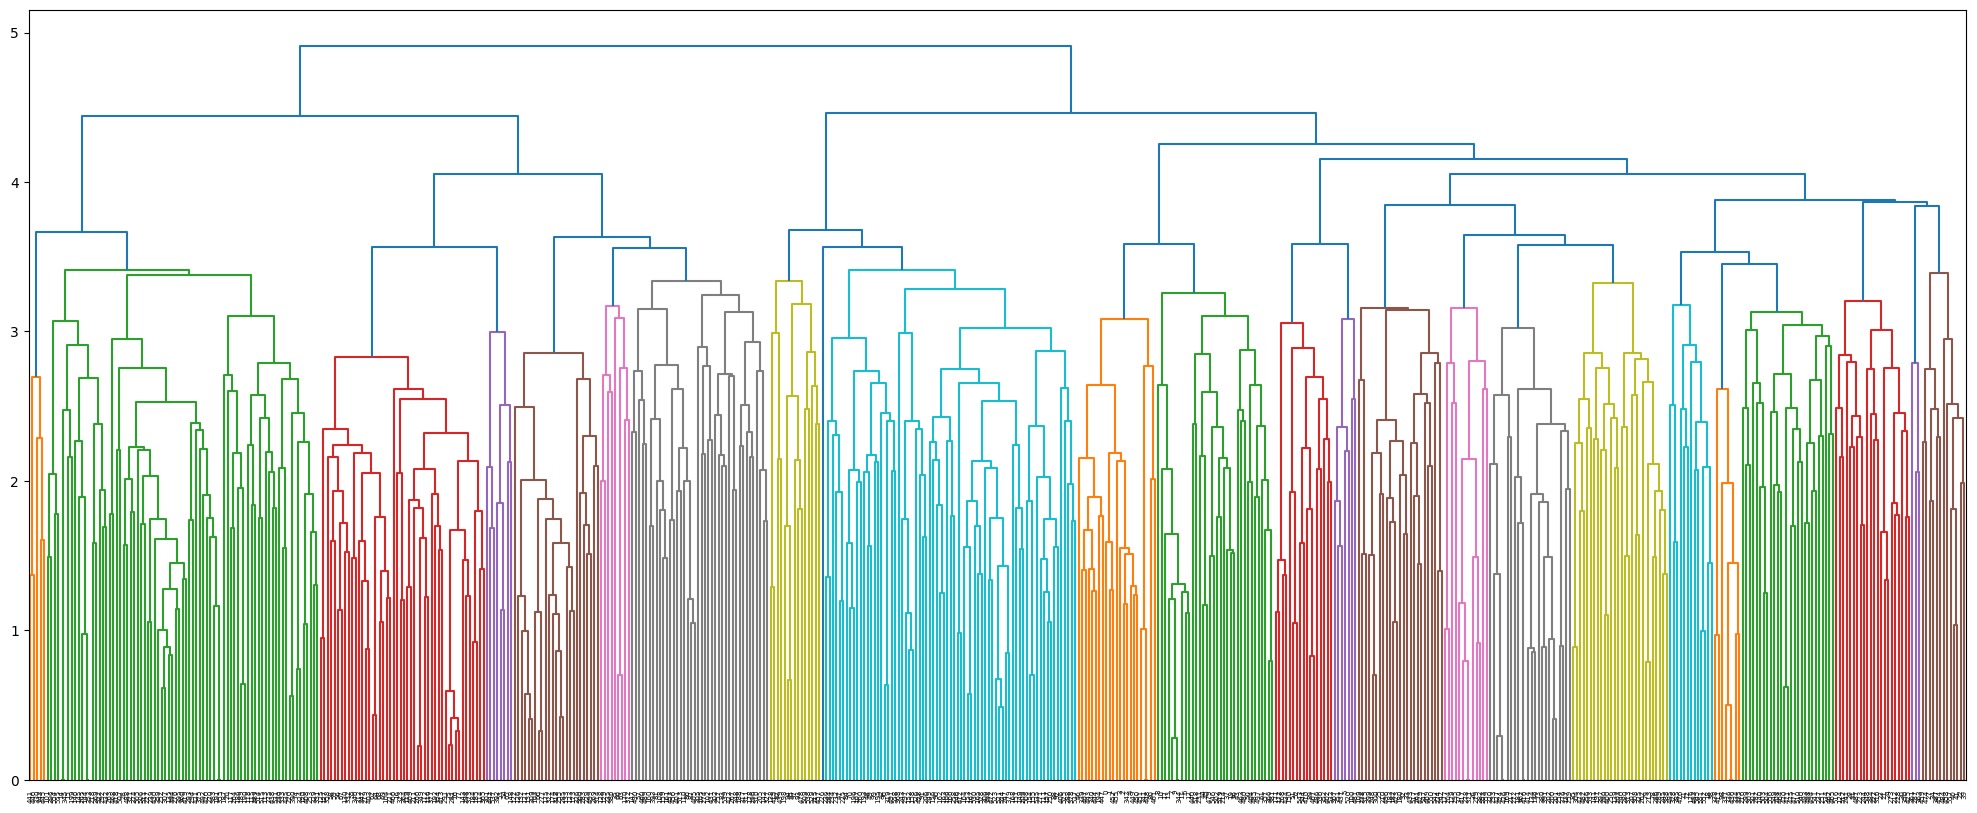

In [92]:
Z = linkage(similarity_matrix4, 'average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [94]:
k=24
number_of_examples = 10
cluster_labels = fcluster(Z, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,"#######")
    cluster_words = {}
    cluster_sentences = []
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            # print(inherent_function_dataset[j])
            cluster_sentences.append(inherent_function_dataset[j])
            for word in inherent_function_dataset[j].split():
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    
    print("Size:", len(cluster_sentences))
    print("Example sentences: ")
    if len(cluster_sentences) < number_of_examples:
        for j in cluster_sentences:
            print(j)
    else:
        example_sentences = np.random.choice(cluster_sentences,number_of_examples, replace=False)
        for j in example_sentences:
            print(j)
            
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(5):
        print(sorted_cluster_words[j])
    print()

Cluster 1 #######
Size: 5
Example sentences: 
CW radiator core leak emitting
air conditioner system leaking emitting
air conditioner accessory drive leaking oil emitting protecting transforming driving
air conditioner drive leaking emitting driving
air conditioner drive leaking oil emitting protecting driving
Top words:
emitting
air
conditioner
leaking
drive

Cluster 2 #######
Size: 79
Example sentences: 
differential leak transforming
differential lube pump leaking PO transforming generating
change out leaking HMU on next driving
investigate torque converter fan pump oil leak generating protecting transforming
dust leak operators side window controlling
replace right hand lift cylinder leaking driving
alternator drive leaking driving generating
PTO shaft input seal leaking covering guiding transforming
change out leaking implement pump generating
oil leak pilot filter text matterprocessing protecting
Top words:
protecting
leak
leaking
oil
driving

Cluster 3 #######
Size: 48
Example se